In [884]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
from imblearn.over_sampling import SMOTE
import statsmodels.api as sm
from sklearn.metrics import (confusion_matrix, 
                           accuracy_score)
from sklearn.model_selection import StratifiedKFold
from statistics import *
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve

# Logistic Regression of Burnout Risk

In [186]:
# Final clean feature table
features = pd.read_csv('burnout.csv')

In [187]:
# Remove unneccessary column and reset index
features.drop(['Unnamed: 0'], axis=1, inplace=True)
features = features.reset_index(drop=True)

In [188]:
len(features.columns.values)

126

In [190]:
features.head()

,User,Date,CupsofCaffeine,AlcoholicDrinks,WakeMethod(0-2),TimeToFallAsleep(0-5),HoursWorked,OverTime(Mins),NoSleep,ShiftType,...,5DaySTDRelaxMorning,7DaySTDRelaxMorning,3DayAverageRelaxEvening,5DayAverageRelaxEvening,7DayAverageRelaxEvening,3DaySTDRelaxEvening,5DaySTDRelaxEvening,7DaySTDRelaxEvening,WRI,Burnout
0,1151,2020-12-20,1.0,1.0,1.0,0.0,0.0,0.0,1.0,NaN,...,21.525798,0.000000,45.000000,56.20,0.000000,7.071068,14.770240,0.000000,NaN,1.0
1,1151,2020-12-22,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,...,24.057223,23.544285,25.000000,33.75,46.833333,25.000000,20.425168,24.909280,NaN,1.0
2,1151,2020-12-23,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,...,17.514280,23.544285,34.000000,42.00,46.000000,34.000000,25.337719,24.090109,NaN,1.0
3,1151,2020-12-24,1.0,2.0,1.0,0.0,8.0,0.0,1.0,1.0,...,29.473505,28.392585,44.000000,45.50,44.500000,31.155524,27.106272,22.596091,NaN,1.0
4,1151,2020-12-25,1.0,0.0,1.0,0.0,8.0,0.0,1.0,1.0,...,34.295590,28.010415,67.666667,50.75,50.500000,2.867442,29.405569,24.012150,-100.0,1.0


## Function to normalize features

In [191]:
def normalize(f, features):
    for u in list(features.User.unique()):
        col = list(features[[f]].values)
        copy_col = []
        for i, v in features.loc[features['User']== u, f].items():
            # Use min max formula
            copy_col.append((v - min(col))/(max(col) - min(col)))
        features.loc[features['User']== u, f] = np.array(copy_col).reshape(-1,1)

## Function to Split Table and fit train/test using SMOTE

In [237]:
def fit_table_sm(table):
    # See if there are any NaNs
    print(table.isnull().sum())
    
    # Remove NaN
    table.dropna(axis=0, inplace=True)
    
    # Split inputs and outputs
    X = table.loc[:,table.columns != 'Burnout']
    y = table[['Burnout']]

    # Because so few participants are at low risk for burnout, use SMOTE... adds new training data
    os = SMOTE(random_state=0)

    # First split training and test data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
    columns = X_train.columns

    # Refit training data with SMOTE to be more evenly distributed
    refit_X_train, refit_y_train = os.fit_resample(X_train, y_train)
    refit_X_train = pd.DataFrame(data=refit_X_train, columns=columns)
    refit_y_train = pd.DataFrame(data=refit_y_train, columns=['Burnout'])
    
    # Print length of training data, non burnout users in training data, non burnout proporiton in training data
    print(len(refit_X_train), len(refit_y_train[refit_y_train['Burnout']==0]), len(refit_y_train[refit_y_train['Burnout']==0])/len(refit_X_train))
    
    return refit_X_train, refit_y_train, X_test, y_test

## Function to split and train data using k-fold (k = 5)

In [389]:
def fit_table_k(table, reg):
    # See if there are any NaNs
    print(table.isnull().sum())
    
    # Remove NaN
    table.dropna(axis=0, inplace=True)
    
    # Split inputs and outputs
    X = table.loc[:,table.columns != 'Burnout']
    y = table[['Burnout']]

    # use stratified k fold so accuracy score minimizes bias in train/test split
    skf = StratifiedKFold(n_splits=5, shuffle=True)
    
    # Initialize df
    model_eval = pd.DataFrame()
    
    # Train logit model 
    for train_index, test_index in skf.split(X, y):
        feats = list(X.columns)
        X_train = table.iloc[train_index].loc[:, feats]
        X_test = table.iloc[test_index][feats]
        y_train = table.iloc[train_index].loc[:,'Burnout']
        y_test = table.iloc[test_index]['Burnout']
        # Print length of training data, non burnout users in training data, non burnout proporiton in training data
        print(len(X_train), sum(y_train), sum(y_train)/len(X_train))
        
        if not reg:
            method = 'newton'
        feats.remove('User')
        for f in feats:
            # Don't normalize categorical
            if '_' not in f:
                normalize(f, X_train)
                normalize(f, X_test)
            # Use bfgs if using categorical variables... due to amount of zeros, sometimes calculating an inverse is impossible
            else:
                if not reg:
                    method = 'bfgs'
                
        X_train.drop(['User'], axis = 1, inplace=True)
        X_test.drop(['User'], axis=1, inplace=True)
        
        
        # Logistic Regression
        if not reg:
            logit_model=sm.Logit(y_train, X_train)
            result = logit_model.fit(method=method)
        else:
            model = LogisticRegression(penalty='l2')
            result = model.fit(X_train,y_train)
        
        test_fold = test_model(result, X_test, y_test)
        model_eval = pd.concat([model_eval, test_fold], axis= 0)
    
    model_eval.set_index(np.array(range(1,6)), drop=True, inplace=True)
    model_eval.loc['FinalScores'] = model_eval.mean()
    return model_eval

## Functions to split and train data (user independent k = # of participants)

In [390]:
def fit_table_uind(table, reg):
    # See if there are any NaNs
    print(table.isnull().sum())
    
    # Remove NaN
    table.dropna(axis=0, inplace=True)

    # split folds by user
    users = list(table.User.unique())
    
    # Reset indices
    table.reset_index(drop=True, inplace=True)
    
    # Initialize df
    model_eval = pd.DataFrame()
    
    # Train logit model 
    for u in users:
        train = list(table.loc[table['User']!= u, :].index)
        test = list(table.loc[table['User']== u, :].index)
        # Split inputs and outputs on training
        feats = list(table.columns)
        feats.remove('Burnout')
        X_train = table.iloc[train].loc[:, feats]
        X_test = table.iloc[test][feats]
        y_train = table.iloc[train].loc[:,'Burnout']
        y_test = table.iloc[test]['Burnout']
        print(len(X_train), sum(y_train), sum(y_train)/len(X_train))
        
        if not reg:
            method = 'newton'
        feats.remove('User')
        for f in feats:
            # Don't normalize categorical
            if '_' not in f:
                normalize(f, X_train)
                normalize(f, X_test)
            # Use bfgs if using categorical variables... due to amount of zeros, sometimes calculating an inverse is impossible
            else:
                if not reg:
                    method = 'bfgs'
                
        X_train.drop(['User'], axis = 1, inplace=True)
        X_test.drop(['User'], axis=1, inplace=True)
        
        
        # Logistic Regression
        if not reg:
            logit_model=sm.Logit(y_train, X_train)
            result = logit_model.fit(method=method)
        else:
            model = LogisticRegression(penalty='l2')
            result = model.fit(X_train,y_train)
        
        test_fold = test_model(result, X_test, y_test)
        model_eval = pd.concat([model_eval, test_fold], axis= 0)
    
    model_eval.set_index(np.array(range(1,(len(users)+1))), drop=True, inplace=True)
    model_eval.loc['FinalScores'] = model_eval.mean()
    return model_eval

## Function to return test model, returns accuracy, precision, recall

In [425]:
def test_model(result, X_test, y_test):
    prediction0 = result.predict(X_test)
    # Using a threshold of 0.5
    prediction = [round(x) for x in list(prediction0)]
    accuracy = accuracy_score(y_test.values, prediction)
    
    matrix = confusion_matrix(y_test, prediction).ravel()
    
    precision = matrix[-1]/(matrix[-1] + matrix[1])
    
    recall = matrix[-1]/(matrix[-1]+matrix[2])
    
    f1 = (2*(precision*recall))/(precision+recall)
    
    evaluated_model = pd.DataFrame([[accuracy, precision, recall, f1]], columns=['Accuracy', 'Precision', 'Recall', 'F1'])
    
    return evaluated_model
    

## Baseline model with Zero Rule Algorithm = 63.97%

In [392]:
# Split inputs and outputs
X = features.loc[:,features.columns != 'Burnout']
y = features[['Burnout']]

accuracy = []
precision = []
recall = []
f1 = []
skf = StratifiedKFold(n_splits=5, shuffle=True)
for trainidx, testidx in skf.split(X, y):
    outputs = list(features.iloc[trainidx].loc[:, 'Burnout'].values)
    y_test = features.iloc[testidx].loc[:, 'Burnout']
    prediction = max(set(outputs), key=outputs.count)
    # Predict most common class for every test observation
    predicted = [prediction for i in range(len(y_test))]
    accuracy.append(accuracy_score(y_test.values, predicted))
    
    matrix = confusion_matrix(y_test, predicted, labels=[0.0,1.0]).ravel()
    
    p = matrix[-1]/(matrix[-1]+matrix[1])
    r = matrix[-1]/(matrix[-1]+matrix[2])
    
    precision.append(p)
    recall.append(r)
    f1.append((2*p*r)/(p+r))
    
evaluated_model = pd.DataFrame([[mean(accuracy), mean(precision), mean(recall), mean(f1)]], columns=['Accuracy', 'Precision', 'Recall', 'F1'])

In [393]:
evaluated_model

,Accuracy,Precision,Recall,F1
0,0.639683,0.639683,1.0,0.780244


## Model with just pure fitbit features no aggregates 

In [397]:
fitbit_ft = features[['User', 'HRMean', 'SleepEfficiency', 'Steps', 'NonActiveEntropy', 'Burnout']]

In [398]:
X_train, y_train, X_test, y_test = fit_table_sm(fitbit_ft)

User                 0
HRMean               0
SleepEfficiency     49
Steps                0
NonActiveEntropy     0
Burnout              0
dtype: int64
424 212 0.5


<ipython-input-237-2782e098628f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table.dropna(axis=0, inplace=True)


In [399]:
# Normalize features
feats = ['HRMean', 'SleepEfficiency', 'Steps', 'NonActiveEntropy']
for f in feats:
    normalize(f, X_train)
    normalize(f, X_test)
X_train.drop(['User'], axis = 1, inplace=True)
X_test.drop(['User'], axis=1, inplace=True)

In [400]:
# Logistic Regression - SMOTE, no regularization
logit_model=sm.Logit(y_train, X_train)
result = logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.672130
         Iterations 4
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.030     
Dependent Variable: Burnout          AIC:              577.9665  
Date:               2021-07-21 18:31 BIC:              594.1654  
No. Observations:   424              Log-Likelihood:   -284.98   
Df Model:           3                LL-Null:          -293.89   
Df Residuals:       420              LLR p-value:      0.00047856
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     4.0000                                       
-----------------------------------------------------------------
                   Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-----------------------------------------------------------------
HRMean             1.6040   0.8826  1.8174 0.0692 -0.1258  3.3338
SleepEfficiency   -0.0067   0.7897 -0.0085 0.9932 -1.5545  1.5410


In [401]:
evaltable = test_model(result, X_test, y_test)

In [402]:
evaltable

,Accuracy,Precision,Recall,F1
0,0.604478,0.717949,0.643678,0.678788


**K folds (5-fold and Leave one out)**

In [403]:
# Generalized, regularization
fitbit_ft = features[['User', 'HRMean', 'SleepEfficiency', 'Steps', 'NonActiveEntropy', 'Burnout']]
fit_table_k(fitbit_ft, reg=True)

User                 0
HRMean               0
SleepEfficiency     49
Steps                0
NonActiveEntropy     0
Burnout              0
dtype: int64
356 239.0 0.6713483146067416


<ipython-input-389-73e8ed4c0d83>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table.dropna(axis=0, inplace=True)


356 239.0 0.6713483146067416
356 239.0 0.6713483146067416
356 239.0 0.6713483146067416
356 240.0 0.6741573033707865


,Accuracy,Precision,Recall,F1
1,0.775281,0.750000,1.000000,0.857143
2,0.741573,0.753425,0.916667,0.827068
3,0.674157,0.738462,0.800000,0.768000
4,0.797753,0.769231,1.000000,0.869565
5,0.764045,0.737500,1.000000,0.848921
FinalScores,0.750562,0.749723,0.943333,0.834139


In [405]:
# No regularization, generalized
fitbit_ft = features[['User', 'HRMean', 'SleepEfficiency', 'Steps', 'NonActiveEntropy', 'Burnout']]
fit_table_k(fitbit_ft, reg=False)

User                 0
HRMean               0
SleepEfficiency     49
Steps                0
NonActiveEntropy     0
Burnout              0
dtype: int64
356 239.0 0.6713483146067416


<ipython-input-389-73e8ed4c0d83>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table.dropna(axis=0, inplace=True)


Optimization terminated successfully.
         Current function value: 0.571493
         Iterations 5
356 239.0 0.6713483146067416
Optimization terminated successfully.
         Current function value: 0.591870
         Iterations 5
356 239.0 0.6713483146067416
Optimization terminated successfully.
         Current function value: 0.597366
         Iterations 5
356 239.0 0.6713483146067416
Optimization terminated successfully.
         Current function value: 0.581825
         Iterations 5
356 240.0 0.6741573033707865
Optimization terminated successfully.
         Current function value: 0.579477
         Iterations 5


,Accuracy,Precision,Recall,F1
1,0.662921,0.714286,0.833333,0.769231
2,0.764045,0.760000,0.950000,0.844444
3,0.685393,0.750000,0.800000,0.774194
4,0.764045,0.800000,0.866667,0.832000
5,0.696629,0.700000,0.949153,0.805755
FinalScores,0.714607,0.744857,0.879831,0.805125


In [424]:
# User independent, No regularization
fitbit_ft = features[['User', 'HRMean', 'SleepEfficiency', 'Steps', 'NonActiveEntropy', 'Burnout']]
fit_table_uind(fitbit_ft, reg=False)

User                 0
HRMean               0
SleepEfficiency     49
Steps                0
NonActiveEntropy     0
Burnout              0
dtype: int64
414 268.0 0.6473429951690821


<ipython-input-390-dcfddfb2095b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table.dropna(axis=0, inplace=True)


Optimization terminated successfully.
         Current function value: 0.581290
         Iterations 6
[ 0  0 30  1]
414 268.0 0.6473429951690821
Optimization terminated successfully.
         Current function value: 0.600155
         Iterations 5
[ 0  0 25  6]
412 266.0 0.6456310679611651
Optimization terminated successfully.
         Current function value: 0.601859
         Iterations 5
[ 0  0 25  8]
428 282.0 0.6588785046728972
Optimization terminated successfully.
         Current function value: 0.604078
         Iterations 5
[ 0  0 12  5]
411 265.0 0.6447688564476886
Optimization terminated successfully.
         Current function value: 0.612095
         Iterations 5
[ 0  0 24 10]
411 265.0 0.6447688564476886
Optimization terminated successfully.
         Current function value: 0.590365
         Iterations 5
[ 0  0 30  4]
417 271.0 0.6498800959232613
Optimization terminated successfully.
         Current function value: 0.613673
         Iterations 5
[ 0  0 21  7]
413 267.0 0.64

<ipython-input-423-e22eac0258f0>:16: RuntimeWarning: invalid value encountered in long_scalars
  recall = matrix[-1]/(matrix[-1]+matrix[2])


Optimization terminated successfully.
         Current function value: 0.501734
         Iterations 6
[22  9  0  0]
429 299.0 0.696969696969697


<ipython-input-423-e22eac0258f0>:16: RuntimeWarning: invalid value encountered in long_scalars
  recall = matrix[-1]/(matrix[-1]+matrix[2])


Optimization terminated successfully.
         Current function value: 0.563002
         Iterations 6
[12  4  0  0]
412 299.0 0.7257281553398058


<ipython-input-423-e22eac0258f0>:16: RuntimeWarning: invalid value encountered in long_scalars
  recall = matrix[-1]/(matrix[-1]+matrix[2])


Optimization terminated successfully.
         Current function value: 0.519405
         Iterations 6
[12 21  0  0]
412 299.0 0.7257281553398058


<ipython-input-423-e22eac0258f0>:16: RuntimeWarning: invalid value encountered in long_scalars
  recall = matrix[-1]/(matrix[-1]+matrix[2])


Optimization terminated successfully.
         Current function value: 0.587401
         Iterations 5
[ 8 25  0  0]
418 299.0 0.715311004784689


<ipython-input-423-e22eac0258f0>:16: RuntimeWarning: invalid value encountered in long_scalars
  recall = matrix[-1]/(matrix[-1]+matrix[2])


Optimization terminated successfully.
         Current function value: 0.569218
         Iterations 5
[12 15  0  0]


<ipython-input-423-e22eac0258f0>:16: RuntimeWarning: invalid value encountered in long_scalars
  recall = matrix[-1]/(matrix[-1]+matrix[2])


,Accuracy,Precision,Recall,F1
1,0.032258,1.000,0.032258,0.062500
2,0.193548,1.000,0.193548,0.324324
3,0.242424,1.000,0.242424,0.390244
4,0.294118,1.000,0.294118,0.454545
5,0.294118,1.000,0.294118,0.454545
6,0.117647,1.000,0.117647,0.210526
7,0.250000,1.000,0.250000,0.400000
8,0.312500,1.000,0.312500,0.476190
9,0.290323,1.000,0.290323,0.450000
10,0.607143,1.000,0.607143,0.755556


In [422]:
# User independent, regularization
fitbit_ft = features[['User', 'HRMean', 'SleepEfficiency', 'Steps', 'NonActiveEntropy', 'Burnout']]
fit_table_uind(fitbit_ft, reg=True)

User                 0
HRMean               0
SleepEfficiency     49
Steps                0
NonActiveEntropy     0
Burnout              0
dtype: int64
414 268.0 0.6473429951690821


<ipython-input-390-dcfddfb2095b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table.dropna(axis=0, inplace=True)


414 268.0 0.6473429951690821
412 266.0 0.6456310679611651
428 282.0 0.6588785046728972
411 265.0 0.6447688564476886
411 265.0 0.6447688564476886
417 271.0 0.6498800959232613
413 267.0 0.6464891041162227
414 268.0 0.6473429951690821
417 271.0 0.6498800959232613
439 299.0 0.6810933940774487


<ipython-input-421-ae76f0bec9db>:15: RuntimeWarning: invalid value encountered in long_scalars
  recall = matrix[-1]/(matrix[-1]+matrix[2])


414 299.0 0.7222222222222222


<ipython-input-421-ae76f0bec9db>:15: RuntimeWarning: invalid value encountered in long_scalars
  recall = matrix[-1]/(matrix[-1]+matrix[2])


429 299.0 0.696969696969697


<ipython-input-421-ae76f0bec9db>:15: RuntimeWarning: invalid value encountered in long_scalars
  recall = matrix[-1]/(matrix[-1]+matrix[2])


412 299.0 0.7257281553398058


<ipython-input-421-ae76f0bec9db>:15: RuntimeWarning: invalid value encountered in long_scalars
  recall = matrix[-1]/(matrix[-1]+matrix[2])


412 299.0 0.7257281553398058


<ipython-input-421-ae76f0bec9db>:15: RuntimeWarning: invalid value encountered in long_scalars
  recall = matrix[-1]/(matrix[-1]+matrix[2])


418 299.0 0.715311004784689


<ipython-input-421-ae76f0bec9db>:15: RuntimeWarning: invalid value encountered in long_scalars
  recall = matrix[-1]/(matrix[-1]+matrix[2])


,Accuracy,Precision,Recall,F1
1,0.903226,1.000,0.903226,0.949153
2,1.000000,1.000,1.000000,1.000000
3,0.969697,1.000,0.969697,0.984615
4,0.882353,1.000,0.882353,0.937500
5,0.970588,1.000,0.970588,0.985075
6,0.794118,1.000,0.794118,0.885246
7,0.964286,1.000,0.964286,0.981818
8,0.968750,1.000,0.968750,0.984127
9,0.838710,1.000,0.838710,0.912281
10,1.000000,1.000,1.000000,1.000000


## Models with aggregate fitbit features (no wellbeing) 

In [407]:
fitbit_agg1 = features[['User', 'HRMean', 'SleepEfficiency','NonActiveEntropy', 'Burnout', '3DayAverageSleepEfficiency', '5DaySTDSleepDuration', '7DayAverageHRMean' ,'3DayAverageSteps']]

In [408]:
X_train, y_train, X_test, y_test = fit_table_sm(fitbit_agg1)

User                           0
HRMean                         0
SleepEfficiency               49
NonActiveEntropy               0
Burnout                        0
3DayAverageSleepEfficiency     7
5DaySTDSleepDuration           1
7DayAverageHRMean              0
3DayAverageSteps               0
dtype: int64
424 212 0.5


<ipython-input-237-2782e098628f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table.dropna(axis=0, inplace=True)


In [409]:
# Normalize features
feats = ['HRMean', 'SleepEfficiency','NonActiveEntropy', '3DayAverageSleepEfficiency', '5DaySTDSleepDuration', '7DayAverageHRMean' ,'3DayAverageSteps']
for f in feats:
    normalize(f, X_train)
    normalize(f, X_test)
X_train.drop(['User'], axis = 1, inplace=True)
X_test.drop(['User'], axis=1, inplace=True)

In [410]:
# Logistic Regression - SMOTE, no regularization
logit_model=sm.Logit(y_train, X_train)
result = logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.672421
         Iterations 4
                              Results: Logit
Model:                  Logit               Pseudo R-squared:    0.030    
Dependent Variable:     Burnout             AIC:                 584.2134 
Date:                   2021-07-21 18:35    BIC:                 612.5615 
No. Observations:       424                 Log-Likelihood:      -285.11  
Df Model:               6                   LL-Null:             -293.89  
Df Residuals:           417                 LLR p-value:         0.0073855
Converged:              1.0000              Scale:               1.0000   
No. Iterations:         4.0000                                            
--------------------------------------------------------------------------
                            Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
--------------------------------------------------------------------------
HRMean                      

In [411]:
evalmodel = test_model(result,X_test,y_test)

In [412]:
evalmodel

,Accuracy,Precision,Recall,F1
0,0.58209,0.666667,0.712644,0.688889


**K folds (5-fold and Leave one out)**

In [413]:
# Generalized model, regularized
fitbit_agg1 = features[['User', 'HRMean', 'SleepEfficiency','NonActiveEntropy', 'Burnout', '3DayAverageSleepEfficiency', '5DaySTDSleepDuration', '7DayAverageHRMean' ,'3DayAverageSteps']]
fit_table_k(fitbit_agg1, reg=True)

User                           0
HRMean                         0
SleepEfficiency               49
NonActiveEntropy               0
Burnout                        0
3DayAverageSleepEfficiency     7
5DaySTDSleepDuration           1
7DayAverageHRMean              0
3DayAverageSteps               0
dtype: int64
356 239.0 0.6713483146067416


<ipython-input-389-73e8ed4c0d83>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table.dropna(axis=0, inplace=True)


356 239.0 0.6713483146067416
356 239.0 0.6713483146067416
356 239.0 0.6713483146067416
356 240.0 0.6741573033707865


,Accuracy,Precision,Recall,F1
1,0.719101,0.727273,0.933333,0.817518
2,0.764045,0.782609,0.900000,0.837209
3,0.707865,0.712500,0.950000,0.814286
4,0.764045,0.767123,0.933333,0.842105
5,0.741573,0.736842,0.949153,0.829630
FinalScores,0.739326,0.745269,0.933164,0.828150


In [426]:
fitbit_agg1 = features[['User', 'HRMean', 'SleepEfficiency','NonActiveEntropy', 'Burnout', '3DayAverageSleepEfficiency', '5DaySTDSleepDuration', '7DayAverageHRMean' ,'3DayAverageSteps']]
fit_table_uind(fitbit_agg1, reg=True)

User                           0
HRMean                         0
SleepEfficiency               49
NonActiveEntropy               0
Burnout                        0
3DayAverageSleepEfficiency     7
5DaySTDSleepDuration           1
7DayAverageHRMean              0
3DayAverageSteps               0
dtype: int64
414 268.0 0.6473429951690821


<ipython-input-390-dcfddfb2095b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table.dropna(axis=0, inplace=True)


414 268.0 0.6473429951690821
412 266.0 0.6456310679611651
428 282.0 0.6588785046728972
411 265.0 0.6447688564476886
411 265.0 0.6447688564476886
417 271.0 0.6498800959232613
413 267.0 0.6464891041162227
414 268.0 0.6473429951690821
417 271.0 0.6498800959232613
439 299.0 0.6810933940774487


<ipython-input-425-b9704e424951>:15: RuntimeWarning: invalid value encountered in long_scalars
  recall = matrix[-1]/(matrix[-1]+matrix[2])


414 299.0 0.7222222222222222


<ipython-input-425-b9704e424951>:15: RuntimeWarning: invalid value encountered in long_scalars
  recall = matrix[-1]/(matrix[-1]+matrix[2])


429 299.0 0.696969696969697


<ipython-input-425-b9704e424951>:15: RuntimeWarning: invalid value encountered in long_scalars
  recall = matrix[-1]/(matrix[-1]+matrix[2])


412 299.0 0.7257281553398058


<ipython-input-425-b9704e424951>:15: RuntimeWarning: invalid value encountered in long_scalars
  recall = matrix[-1]/(matrix[-1]+matrix[2])


412 299.0 0.7257281553398058


<ipython-input-425-b9704e424951>:15: RuntimeWarning: invalid value encountered in long_scalars
  recall = matrix[-1]/(matrix[-1]+matrix[2])


418 299.0 0.715311004784689


<ipython-input-425-b9704e424951>:15: RuntimeWarning: invalid value encountered in long_scalars
  recall = matrix[-1]/(matrix[-1]+matrix[2])


,Accuracy,Precision,Recall,F1
1,0.903226,1.000,0.903226,0.949153
2,1.000000,1.000,1.000000,1.000000
3,0.848485,1.000,0.848485,0.918033
4,0.941176,1.000,0.941176,0.969697
5,0.970588,1.000,0.970588,0.985075
6,0.735294,1.000,0.735294,0.847458
7,0.964286,1.000,0.964286,0.981818
8,0.968750,1.000,0.968750,0.984127
9,0.806452,1.000,0.806452,0.892857
10,1.000000,1.000,1.000000,1.000000


## Model with fitbit and survey data (No wellbeing)

In [427]:
fit_survey_ft = features[['User', 'HRMean', 'SleepEfficiency', 'Steps', 'AlcoholicDrinks','CupsofCaffeine', 'HoursWorked', 'NonActiveEntropy', 'Burnout']]
dummy_caf = pd.get_dummies(fit_survey_ft['CupsofCaffeine'], prefix='caf')
dummy_alc = pd.get_dummies(fit_survey_ft['AlcoholicDrinks'], prefix='alc')
dummy_work = pd.get_dummies(fit_survey_ft['HoursWorked'], prefix='workhrs')

In [428]:
fit_survey_ft = pd.concat([fit_survey_ft, dummy_caf, dummy_alc, dummy_work], axis=1)
fit_survey_ft.drop(['CupsofCaffeine', 'AlcoholicDrinks', 'HoursWorked'], axis=1, inplace=True)

In [429]:
fit_survey_ft.head()

,User,HRMean,SleepEfficiency,Steps,NonActiveEntropy,Burnout,caf_0.0,caf_1.0,caf_2.0,caf_3.0,alc_0.0,alc_1.0,alc_2.0,workhrs_0.0,workhrs_8.0
0,1151,59.972875,94.0,1601.0,2.033000,1.0,0,1,0,0,0,1,0,1,0
1,1151,75.776151,87.0,10192.0,2.410910,1.0,1,0,0,0,1,0,0,1,0
2,1151,83.899095,92.0,13175.0,2.171944,1.0,1,0,0,0,1,0,0,1,0
3,1151,71.334032,89.0,7848.0,3.030567,1.0,0,1,0,0,0,0,1,0,1
4,1151,72.139875,96.0,7151.0,2.389942,1.0,0,1,0,0,1,0,0,0,1


In [430]:
X_train, y_train, X_test, y_test = fit_table_sm(fit_survey_ft)

User                 0
HRMean               0
SleepEfficiency     49
Steps                0
NonActiveEntropy     0
Burnout              0
caf_0.0              0
caf_1.0              0
caf_2.0              0
caf_3.0              0
alc_0.0              0
alc_1.0              0
alc_2.0              0
workhrs_0.0          0
workhrs_8.0          0
dtype: int64
424 212 0.5


In [431]:
feats = ['HRMean', 'SleepEfficiency', 'Steps', 'NonActiveEntropy']
for f in feats:
    normalize(f, X_train)
    normalize(f, X_test)
X_train.drop(['User'], axis = 1, inplace=True)
X_test.drop(['User'], axis=1, inplace=True)

In [432]:
# Logistic Regression - SMOTE, no regularization
logit_model=sm.Logit(y_train, X_train)
result = logit_model.fit()
print(result.summary2())

         Current function value: 0.509175
         Iterations: 35
                               Results: Logit
Model:                  Logit                Pseudo R-squared:     0.265     
Dependent Variable:     Burnout              AIC:                  457.7801  
Date:                   2021-07-21 18:50     BIC:                  510.4267  
No. Observations:       424                  Log-Likelihood:       -215.89   
Df Model:               12                   LL-Null:              -293.89   
Df Residuals:           411                  LLR p-value:          3.4114e-27
Converged:              0.0000               Scale:                1.0000    
No. Iterations:         35.0000                                              
-----------------------------------------------------------------------------
                  Coef.     Std.Err.     z    P>|z|     [0.025       0.975]  
-----------------------------------------------------------------------------
HRMean             0.7828     

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [433]:
evalmodel = test_model(result,X_test,y_test)
evalmodel

,Accuracy,Precision,Recall,F1
0,0.664179,0.828125,0.609195,0.701987


**K folds (5-fold and Leave one out)**

In [434]:
fit_survey_ft = features[['User', 'HRMean', 'SleepEfficiency', 'Steps', 'AlcoholicDrinks','CupsofCaffeine', 'HoursWorked', 'NonActiveEntropy', 'Burnout']]
dummy_caf = pd.get_dummies(fit_survey_ft['CupsofCaffeine'], prefix='caf')
dummy_alc = pd.get_dummies(fit_survey_ft['AlcoholicDrinks'], prefix='alc')
dummy_work = pd.get_dummies(fit_survey_ft['HoursWorked'], prefix='workhrs')

In [435]:
fit_survey_ft = pd.concat([fit_survey_ft, dummy_caf, dummy_alc, dummy_work], axis=1)
fit_survey_ft.drop(['CupsofCaffeine', 'AlcoholicDrinks', 'HoursWorked'], axis=1, inplace=True)

In [436]:
# generalized model with regularization
fit_table_k(fit_survey_ft, reg=True)

User                 0
HRMean               0
SleepEfficiency     49
Steps                0
NonActiveEntropy     0
Burnout              0
caf_0.0              0
caf_1.0              0
caf_2.0              0
caf_3.0              0
alc_0.0              0
alc_1.0              0
alc_2.0              0
workhrs_0.0          0
workhrs_8.0          0
dtype: int64
356 239.0 0.6713483146067416
356 239.0 0.6713483146067416
356 239.0 0.6713483146067416
356 239.0 0.6713483146067416
356 240.0 0.6741573033707865


,Accuracy,Precision,Recall,F1
1,0.831461,0.835821,0.933333,0.881890
2,0.741573,0.768116,0.883333,0.821705
3,0.797753,0.850000,0.850000,0.850000
4,0.786517,0.788732,0.933333,0.854962
5,0.808989,0.838710,0.881356,0.859504
FinalScores,0.793258,0.816276,0.896271,0.853612


In [437]:
fit_survey_ft = features[['User', 'HRMean', 'SleepEfficiency', 'Steps', 'AlcoholicDrinks','CupsofCaffeine', 'HoursWorked', 'NonActiveEntropy', 'Burnout']]
dummy_caf = pd.get_dummies(fit_survey_ft['CupsofCaffeine'], prefix='caf')
dummy_alc = pd.get_dummies(fit_survey_ft['AlcoholicDrinks'], prefix='alc')
dummy_work = pd.get_dummies(fit_survey_ft['HoursWorked'], prefix='workhrs')

In [438]:
fit_survey_ft = pd.concat([fit_survey_ft, dummy_caf, dummy_alc, dummy_work], axis=1)
fit_survey_ft.drop(['CupsofCaffeine', 'AlcoholicDrinks', 'HoursWorked'], axis=1, inplace=True)

In [439]:
# User independent , regularized
fit_table_uind(fit_survey_ft, reg=True)

User                 0
HRMean               0
SleepEfficiency     49
Steps                0
NonActiveEntropy     0
Burnout              0
caf_0.0              0
caf_1.0              0
caf_2.0              0
caf_3.0              0
alc_0.0              0
alc_1.0              0
alc_2.0              0
workhrs_0.0          0
workhrs_8.0          0
dtype: int64
414 268.0 0.6473429951690821
414 268.0 0.6473429951690821
412 266.0 0.6456310679611651
428 282.0 0.6588785046728972
411 265.0 0.6447688564476886
411 265.0 0.6447688564476886
417 271.0 0.6498800959232613
413 267.0 0.6464891041162227
414 268.0 0.6473429951690821
417 271.0 0.6498800959232613
439 299.0 0.6810933940774487


<ipython-input-425-b9704e424951>:15: RuntimeWarning: invalid value encountered in long_scalars
  recall = matrix[-1]/(matrix[-1]+matrix[2])


414 299.0 0.7222222222222222


<ipython-input-425-b9704e424951>:15: RuntimeWarning: invalid value encountered in long_scalars
  recall = matrix[-1]/(matrix[-1]+matrix[2])


429 299.0 0.696969696969697


<ipython-input-425-b9704e424951>:15: RuntimeWarning: invalid value encountered in long_scalars
  recall = matrix[-1]/(matrix[-1]+matrix[2])


412 299.0 0.7257281553398058


<ipython-input-425-b9704e424951>:15: RuntimeWarning: invalid value encountered in long_scalars
  recall = matrix[-1]/(matrix[-1]+matrix[2])


412 299.0 0.7257281553398058


<ipython-input-425-b9704e424951>:15: RuntimeWarning: invalid value encountered in long_scalars
  recall = matrix[-1]/(matrix[-1]+matrix[2])


418 299.0 0.715311004784689


<ipython-input-425-b9704e424951>:15: RuntimeWarning: invalid value encountered in long_scalars
  recall = matrix[-1]/(matrix[-1]+matrix[2])


,Accuracy,Precision,Recall,F1
1,0.935484,1.000,0.935484,0.966667
2,1.000000,1.000,1.000000,1.000000
3,0.969697,1.000,0.969697,0.984615
4,0.882353,1.000,0.882353,0.937500
5,1.000000,1.000,1.000000,1.000000
6,0.735294,1.000,0.735294,0.847458
7,0.892857,1.000,0.892857,0.943396
8,0.937500,1.000,0.937500,0.967742
9,0.935484,1.000,0.935484,0.966667
10,1.000000,1.000,1.000000,1.000000


## Model with just wellbeing 

In [440]:
wellbeing_ft = features[['User', 'HappinessEvening', 'EnergyEvening', 'HealthEvening', 'HappinessMorning', 'Burnout']]

In [441]:
X_train, y_train, X_test, y_test = fit_table_sm(wellbeing_ft)

User                  0
HappinessEvening    143
EnergyEvening       143
HealthEvening       143
HappinessMorning    141
Burnout               0
dtype: int64
342 171 0.5


<ipython-input-237-2782e098628f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table.dropna(axis=0, inplace=True)


In [442]:
feats = ['HappinessEvening', 'EnergyEvening', 'HealthEvening', 'HappinessMorning']
for f in feats:
    normalize(f, X_train)
    normalize(f, X_test)
X_train.drop(['User'], axis = 1, inplace=True)
X_test.drop(['User'], axis=1, inplace=True)

In [443]:
# Logistic Regression - SMOTE, no regularization
logit_model=sm.Logit(y_train, X_train)
result = logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.652822
         Iterations 5
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.058     
Dependent Variable: Burnout          AIC:              454.5300  
Date:               2021-07-21 18:53 BIC:              469.8692  
No. Observations:   342              Log-Likelihood:   -223.26   
Df Model:           3                LL-Null:          -237.06   
Df Residuals:       338              LLR p-value:      4.4435e-06
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     5.0000                                       
-----------------------------------------------------------------
                   Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-----------------------------------------------------------------
HappinessEvening  -1.6065   0.9150 -1.7557 0.0791 -3.4000  0.1869
EnergyEvening     -3.5971   0.9017 -3.9893 0.0001 -5.3644 -1.8298


In [444]:
evalmodel = test_model(result,X_test,y_test)
evalmodel

,Accuracy,Precision,Recall,F1
0,0.394231,0.714286,0.266667,0.38835


**K folds (5-fold and Leave one out)**

In [1277]:
# Generalized, regularization
wellbeing_ft = features[['User', 'HappinessEvening', 'EnergyEvening', 'HealthEvening', 'HappinessMorning', 'Burnout']]
fit_table_k(wellbeing_ft, reg=True)

User                  0
HappinessEvening    143
EnergyEvening       143
HealthEvening       143
HappinessMorning    141
Burnout               0
dtype: int64
275 196.0 0.7127272727272728


<ipython-input-389-73e8ed4c0d83>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table.dropna(axis=0, inplace=True)


275 197.0 0.7163636363636363
275 197.0 0.7163636363636363
275 197.0 0.7163636363636363
276 197.0 0.7137681159420289


,Accuracy,Precision,Recall,F1
1,0.724638,0.754098,0.920000,0.828829
2,0.753623,0.742424,1.000000,0.852174
3,0.826087,0.813559,0.979592,0.888889
4,0.739130,0.781818,0.877551,0.826923
5,0.750000,0.758065,0.959184,0.846847
FinalScores,0.758696,0.769993,0.947265,0.848732


In [1278]:
# User independent, regularization
wellbeing_ft = features[['User', 'HappinessEvening', 'EnergyEvening', 'HealthEvening', 'HappinessMorning', 'Burnout']]
fit_table_uind(wellbeing_ft, reg=True)

User                  0
HappinessEvening    143
EnergyEvening       143
HealthEvening       143
HappinessMorning    141
Burnout               0
dtype: int64
320 222.0 0.69375


<ipython-input-390-dcfddfb2095b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table.dropna(axis=0, inplace=True)


313 215.0 0.6869009584664537
321 223.0 0.6947040498442367
324 226.0 0.6975308641975309
310 212.0 0.6838709677419355
332 234.0 0.7048192771084337
316 218.0 0.689873417721519
325 227.0 0.6984615384615385
311 213.0 0.684887459807074
322 224.0 0.6956521739130435
338 246.0 0.727810650887574


<ipython-input-425-b9704e424951>:15: RuntimeWarning: invalid value encountered in long_scalars
  recall = matrix[-1]/(matrix[-1]+matrix[2])


316 246.0 0.7784810126582279


<ipython-input-425-b9704e424951>:15: RuntimeWarning: invalid value encountered in long_scalars
  recall = matrix[-1]/(matrix[-1]+matrix[2])


332 246.0 0.7409638554216867


<ipython-input-425-b9704e424951>:15: RuntimeWarning: invalid value encountered in long_scalars
  recall = matrix[-1]/(matrix[-1]+matrix[2])


330 246.0 0.7454545454545455


<ipython-input-425-b9704e424951>:15: RuntimeWarning: invalid value encountered in long_scalars
  recall = matrix[-1]/(matrix[-1]+matrix[2])


338 246.0 0.727810650887574


<ipython-input-425-b9704e424951>:15: RuntimeWarning: invalid value encountered in long_scalars
  recall = matrix[-1]/(matrix[-1]+matrix[2])


312 246.0 0.7884615384615384


<ipython-input-425-b9704e424951>:15: RuntimeWarning: invalid value encountered in long_scalars
  recall = matrix[-1]/(matrix[-1]+matrix[2])


,Accuracy,Precision,Recall,F1
1,0.875000,1.000,0.875000,0.933333
2,0.580645,1.000,0.580645,0.734694
3,0.956522,1.000,0.956522,0.977778
4,0.900000,1.000,0.900000,0.947368
5,0.911765,1.000,0.911765,0.953846
6,0.916667,1.000,0.916667,0.956522
7,0.964286,1.000,0.964286,0.981818
8,0.789474,1.000,0.789474,0.882353
9,0.757576,1.000,0.757576,0.862069
10,1.000000,1.000,1.000000,1.000000


## Model with Aggregate wellbeing 

In [447]:
agg_well_ft = features[['User','7DaySTDRelaxEvening','7DaySTDHealthEvening', '7DaySTDEnergyEvening', '7DaySTDAlertnessEvening', '3DayAverageHappinessMorning', 'Burnout']]

In [448]:
X_train, y_train, X_test, y_test = fit_table_sm(agg_well_ft)

User                            0
7DaySTDRelaxEvening            44
7DaySTDHealthEvening           44
7DaySTDEnergyEvening           44
7DaySTDAlertnessEvening        44
3DayAverageHappinessMorning    70
Burnout                         0
dtype: int64
390 195 0.5


<ipython-input-237-2782e098628f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table.dropna(axis=0, inplace=True)


In [449]:
feats = ['7DaySTDRelaxEvening','7DaySTDHealthEvening', '7DaySTDEnergyEvening', '7DaySTDAlertnessEvening', '3DayAverageHappinessMorning']
for f in feats:
    normalize(f, X_train)
    normalize(f, X_test)
X_train.drop(['User'], axis = 1, inplace=True)
X_test.drop(['User'], axis=1, inplace=True)

In [450]:
# Logistic Regression - SMOTE, no regularization
logit_model=sm.Logit(y_train, X_train)
result = logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.638845
         Iterations 5
                              Results: Logit
Model:                  Logit               Pseudo R-squared:    0.078     
Dependent Variable:     Burnout             AIC:                 508.2995  
Date:                   2021-07-21 18:54    BIC:                 528.1302  
No. Observations:       390                 Log-Likelihood:      -249.15   
Df Model:               4                   LL-Null:             -270.33   
Df Residuals:           385                 LLR p-value:         1.4079e-08
Converged:              1.0000              Scale:               1.0000    
No. Iterations:         5.0000                                             
---------------------------------------------------------------------------
                             Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
---------------------------------------------------------------------------
7DaySTDRelaxEveni

In [451]:
evalmodel = test_model(result,X_test,y_test)
evalmodel

,Accuracy,Precision,Recall,F1
0,0.585938,0.846154,0.494382,0.624113


**K folds (5-fold and Leave one out)**

In [453]:
# Generalized model with regularization
agg_well_ft = features[['User','7DaySTDRelaxEvening','7DaySTDHealthEvening', '7DaySTDEnergyEvening', '7DaySTDAlertnessEvening', '3DayAverageHappinessMorning', 'Burnout']]
fit_table_k(agg_well_ft, reg=True)

User                            0
7DaySTDRelaxEvening            44
7DaySTDHealthEvening           44
7DaySTDEnergyEvening           44
7DaySTDAlertnessEvening        44
3DayAverageHappinessMorning    70
Burnout                         0
dtype: int64
339 227.0 0.6696165191740413


<ipython-input-389-73e8ed4c0d83>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table.dropna(axis=0, inplace=True)


339 227.0 0.6696165191740413
339 227.0 0.6696165191740413
339 227.0 0.6696165191740413
340 228.0 0.6705882352941176


,Accuracy,Precision,Recall,F1
1,0.682353,0.678571,1.000000,0.808511
2,0.694118,0.686747,1.000000,0.814286
3,0.741176,0.727273,0.982456,0.835821
4,0.647059,0.675325,0.912281,0.776119
5,0.702381,0.724638,0.892857,0.800000
FinalScores,0.693417,0.698511,0.957519,0.806947


In [454]:
# user indpendent with regularization
agg_well_ft = features[['User','7DaySTDRelaxEvening','7DaySTDHealthEvening', '7DaySTDEnergyEvening', '7DaySTDAlertnessEvening', '3DayAverageHappinessMorning', 'Burnout']]
fit_table_uind(agg_well_ft, reg=True)

User                            0
7DaySTDRelaxEvening            44
7DaySTDHealthEvening           44
7DaySTDEnergyEvening           44
7DaySTDAlertnessEvening        44
3DayAverageHappinessMorning    70
Burnout                         0
dtype: int64
391 251.0 0.6419437340153452


<ipython-input-390-dcfddfb2095b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table.dropna(axis=0, inplace=True)


393 253.0 0.6437659033078881
393 253.0 0.6437659033078881
403 263.0 0.652605459057072
389 249.0 0.6401028277634961
410 270.0 0.6585365853658537
393 253.0 0.6437659033078881
396 256.0 0.6464646464646465
391 251.0 0.6419437340153452
397 257.0 0.6473551637279596
417 284.0 0.6810551558752997


<ipython-input-425-b9704e424951>:15: RuntimeWarning: invalid value encountered in long_scalars
  recall = matrix[-1]/(matrix[-1]+matrix[2])


392 284.0 0.7244897959183674


<ipython-input-425-b9704e424951>:15: RuntimeWarning: invalid value encountered in long_scalars
  recall = matrix[-1]/(matrix[-1]+matrix[2])


389 284.0 0.7300771208226221


<ipython-input-425-b9704e424951>:15: RuntimeWarning: invalid value encountered in long_scalars
  recall = matrix[-1]/(matrix[-1]+matrix[2])


401 284.0 0.7082294264339152


<ipython-input-425-b9704e424951>:15: RuntimeWarning: invalid value encountered in long_scalars
  recall = matrix[-1]/(matrix[-1]+matrix[2])


413 284.0 0.6876513317191283


<ipython-input-425-b9704e424951>:15: RuntimeWarning: invalid value encountered in long_scalars
  recall = matrix[-1]/(matrix[-1]+matrix[2])


392 284.0 0.7244897959183674


<ipython-input-425-b9704e424951>:15: RuntimeWarning: invalid value encountered in long_scalars
  recall = matrix[-1]/(matrix[-1]+matrix[2])


,Accuracy,Precision,Recall,F1
1,0.757576,1.000,0.757576,0.862069
2,0.354839,1.000,0.354839,0.523810
3,0.967742,1.000,0.967742,0.983607
4,0.761905,1.000,0.761905,0.864865
5,0.600000,1.000,0.600000,0.750000
6,0.571429,1.000,0.571429,0.727273
7,0.387097,1.000,0.387097,0.558140
8,0.821429,1.000,0.821429,0.901961
9,0.575758,1.000,0.575758,0.730769
10,0.629630,1.000,0.629630,0.772727


## Model with fitbit survey and aggregate fitbit 

In [455]:
fit_survey_agg = features[['User','HRMean', 'SleepEfficiency', 'Steps', 'NonActiveEntropy', '5DaySTDSleepEfficiency', '5DaySTDSleepDuration', '3DayAverageSteps', 'CupsofCaffeine', 'HoursWorked', 'AlcoholicDrinks','Burnout']]
dummy_caf = pd.get_dummies(fit_survey_agg['CupsofCaffeine'], prefix='caf')
dummy_alc = pd.get_dummies(fit_survey_agg['AlcoholicDrinks'], prefix='alc')
dummy_hrs = pd.get_dummies(fit_survey_agg['HoursWorked'], prefix='hrswork')

In [456]:
fit_survey_agg = pd.concat([fit_survey_agg, dummy_caf], axis=1)
fit_survey_agg = pd.concat([fit_survey_agg, dummy_alc], axis=1)
fit_survey_agg = pd.concat([fit_survey_agg, dummy_hrs], axis=1)
fit_survey_agg.drop(['CupsofCaffeine', 'HoursWorked', 'AlcoholicDrinks'], axis=1, inplace=True)

In [457]:
X_train, y_train, X_test, y_test = fit_table_sm(fit_survey_agg)

User                       0
HRMean                     0
SleepEfficiency           49
Steps                      0
NonActiveEntropy           0
5DaySTDSleepEfficiency     1
5DaySTDSleepDuration       1
3DayAverageSteps           0
Burnout                    0
caf_0.0                    0
caf_1.0                    0
caf_2.0                    0
caf_3.0                    0
alc_0.0                    0
alc_1.0                    0
alc_2.0                    0
hrswork_0.0                0
hrswork_8.0                0
dtype: int64
424 212 0.5


In [458]:
feats = ['HRMean', 'SleepEfficiency', 'Steps', 'NonActiveEntropy', '5DaySTDSleepEfficiency', '5DaySTDSleepDuration', '3DayAverageSteps']
for f in feats:
    normalize(f, X_train)
    normalize(f, X_test)
X_train.drop(['User'], axis = 1, inplace=True)
X_test.drop(['User'], axis=1, inplace=True)

In [459]:
# Logistic Regression - SMOTE, no regularization
logit_model=sm.Logit(y_train, X_train)
result = logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.485412
         Iterations 8
                            Results: Logit
Model:                 Logit             Pseudo R-squared:  0.300     
Dependent Variable:    Burnout           AIC:               443.6291  
Date:                  2021-07-21 18:57  BIC:               508.4249  
No. Observations:      424               Log-Likelihood:    -205.81   
Df Model:              15                LL-Null:           -293.89   
Df Residuals:          408               LLR p-value:       1.4121e-29
Converged:             1.0000            Scale:             1.0000    
No. Iterations:        8.0000                                         
----------------------------------------------------------------------
                        Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
----------------------------------------------------------------------
HRMean                  0.6689   1.0152  0.6589 0.5100 -1.3209  2.6588
Sle

In [460]:
evalmodel = test_model(result,X_test,y_test)
evalmodel

,Accuracy,Precision,Recall,F1
0,0.679104,0.833333,0.632184,0.718954


**K folds (5-fold and Leave one out)**

In [461]:
fit_survey_agg = features[['User','HRMean', 'SleepEfficiency', 'Steps', 'NonActiveEntropy', '5DaySTDSleepEfficiency', '5DaySTDSleepDuration', '3DayAverageSteps', 'CupsofCaffeine', 'HoursWorked', 'AlcoholicDrinks','Burnout']]
dummy_caf = pd.get_dummies(fit_survey_agg['CupsofCaffeine'], prefix='caf')
dummy_alc = pd.get_dummies(fit_survey_agg['AlcoholicDrinks'], prefix='alc')
dummy_hrs = pd.get_dummies(fit_survey_agg['HoursWorked'], prefix='hrswork')

In [462]:
fit_survey_agg = pd.concat([fit_survey_agg, dummy_caf], axis=1)
fit_survey_agg = pd.concat([fit_survey_agg, dummy_alc], axis=1)
fit_survey_agg = pd.concat([fit_survey_agg, dummy_hrs], axis=1)
fit_survey_agg.drop(['CupsofCaffeine', 'HoursWorked', 'AlcoholicDrinks'], axis=1, inplace=True)

In [463]:
# Generalized model with regularization
fit_table_k(fit_survey_agg, reg=True)

User                       0
HRMean                     0
SleepEfficiency           49
Steps                      0
NonActiveEntropy           0
5DaySTDSleepEfficiency     1
5DaySTDSleepDuration       1
3DayAverageSteps           0
Burnout                    0
caf_0.0                    0
caf_1.0                    0
caf_2.0                    0
caf_3.0                    0
alc_0.0                    0
alc_1.0                    0
alc_2.0                    0
hrswork_0.0                0
hrswork_8.0                0
dtype: int64
356 239.0 0.6713483146067416
356 239.0 0.6713483146067416
356 239.0 0.6713483146067416
356 239.0 0.6713483146067416
356 240.0 0.6741573033707865


,Accuracy,Precision,Recall,F1
1,0.752809,0.743590,0.966667,0.840580
2,0.775281,0.833333,0.833333,0.833333
3,0.808989,0.830769,0.900000,0.864000
4,0.707865,0.793103,0.766667,0.779661
5,0.685393,0.731343,0.830508,0.777778
FinalScores,0.746067,0.786428,0.859435,0.819070


In [464]:
fit_survey_agg = features[['User','HRMean', 'SleepEfficiency', 'Steps', 'NonActiveEntropy', '5DaySTDSleepEfficiency', '5DaySTDSleepDuration', '3DayAverageSteps', 'CupsofCaffeine', 'HoursWorked', 'AlcoholicDrinks','Burnout']]
dummy_caf = pd.get_dummies(fit_survey_agg['CupsofCaffeine'], prefix='caf')
dummy_alc = pd.get_dummies(fit_survey_agg['AlcoholicDrinks'], prefix='alc')
dummy_hrs = pd.get_dummies(fit_survey_agg['HoursWorked'], prefix='hrswork')

In [465]:
fit_survey_agg = pd.concat([fit_survey_agg, dummy_caf], axis=1)
fit_survey_agg = pd.concat([fit_survey_agg, dummy_alc], axis=1)
fit_survey_agg = pd.concat([fit_survey_agg, dummy_hrs], axis=1)
fit_survey_agg.drop(['CupsofCaffeine', 'HoursWorked', 'AlcoholicDrinks'], axis=1, inplace=True)

In [467]:
# user independent with regularization
fit_table_uind(fit_survey_agg, reg=True)

User                       0
HRMean                     0
SleepEfficiency           49
Steps                      0
NonActiveEntropy           0
5DaySTDSleepEfficiency     1
5DaySTDSleepDuration       1
3DayAverageSteps           0
Burnout                    0
caf_0.0                    0
caf_1.0                    0
caf_2.0                    0
caf_3.0                    0
alc_0.0                    0
alc_1.0                    0
alc_2.0                    0
hrswork_0.0                0
hrswork_8.0                0
dtype: int64
414 268.0 0.6473429951690821
414 268.0 0.6473429951690821
412 266.0 0.6456310679611651
428 282.0 0.6588785046728972
411 265.0 0.6447688564476886
411 265.0 0.6447688564476886
417 271.0 0.6498800959232613
413 267.0 0.6464891041162227
414 268.0 0.6473429951690821
417 271.0 0.6498800959232613
439 299.0 0.6810933940774487


<ipython-input-425-b9704e424951>:15: RuntimeWarning: invalid value encountered in long_scalars
  recall = matrix[-1]/(matrix[-1]+matrix[2])


414 299.0 0.7222222222222222


<ipython-input-425-b9704e424951>:15: RuntimeWarning: invalid value encountered in long_scalars
  recall = matrix[-1]/(matrix[-1]+matrix[2])


429 299.0 0.696969696969697


<ipython-input-425-b9704e424951>:15: RuntimeWarning: invalid value encountered in long_scalars
  recall = matrix[-1]/(matrix[-1]+matrix[2])


412 299.0 0.7257281553398058


<ipython-input-425-b9704e424951>:15: RuntimeWarning: invalid value encountered in long_scalars
  recall = matrix[-1]/(matrix[-1]+matrix[2])


412 299.0 0.7257281553398058


<ipython-input-425-b9704e424951>:15: RuntimeWarning: invalid value encountered in long_scalars
  recall = matrix[-1]/(matrix[-1]+matrix[2])


418 299.0 0.715311004784689


<ipython-input-425-b9704e424951>:15: RuntimeWarning: invalid value encountered in long_scalars
  recall = matrix[-1]/(matrix[-1]+matrix[2])


,Accuracy,Precision,Recall,F1
1,0.903226,1.000,0.903226,0.949153
2,1.000000,1.000,1.000000,1.000000
3,0.969697,1.000,0.969697,0.984615
4,0.941176,1.000,0.941176,0.969697
5,1.000000,1.000,1.000000,1.000000
6,0.735294,1.000,0.735294,0.847458
7,0.785714,1.000,0.785714,0.880000
8,0.906250,1.000,0.906250,0.950820
9,0.870968,1.000,0.870968,0.931034
10,0.964286,1.000,0.964286,0.981818


## Add Wellbeing to previous table, remove survey feats

In [814]:
all_fts = features[['User', 'HRMean', 'SleepEfficiency', 'Steps','5DaySTDSleepDuration', 'HoursWorked','CupsofCaffeine', '3DayAverageSteps', 'HappinessEvening', '7DaySTDEnergyEvening', 'HealthEvening', '3DayAverageHappinessMorning', 'Burnout']]
dummy_caf = pd.get_dummies(all_fts['CupsofCaffeine'], prefix='caf')
dummy_hrs = pd.get_dummies(all_fts['HoursWorked'], prefix='hrswork')

In [ ]:
all_fts = pd.concat([all_fts, dummy_caf], axis=1)
all_fts = pd.concat([all_fts, dummy_hrs], axis=1)
all_fts.drop(['CupsofCaffeine','HoursWorked'], axis=1, inplace=True)

In [816]:
X_train, y_train, X_test, y_test = fit_table_sm(all_fts)

User                             0
HRMean                           0
SleepEfficiency                 49
Steps                            0
5DaySTDSleepDuration             1
3DayAverageSteps                 0
HappinessEvening               143
7DaySTDEnergyEvening            44
HealthEvening                  143
3DayAverageHappinessMorning     70
Burnout                          0
dtype: int64
322 161 0.5


<ipython-input-237-2782e098628f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table.dropna(axis=0, inplace=True)


In [817]:
feats = ['HRMean', 'SleepEfficiency', 'Steps','5DaySTDSleepDuration', '3DayAverageSteps', 'HappinessEvening', '7DaySTDEnergyEvening', 'HealthEvening', '3DayAverageHappinessMorning']
for f in feats:
    normalize(f, X_train)
    normalize(f, X_test)
X_train.drop(['User'], axis = 1, inplace=True)
X_test.drop(['User'], axis=1, inplace=True)

In [818]:
# Logistic Regression - SMOTE, no regularization
logit_model=sm.Logit(y_train, X_train)
result = logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.629809
         Iterations 5
                              Results: Logit
Model:                  Logit               Pseudo R-squared:    0.091     
Dependent Variable:     Burnout             AIC:                 423.5971  
Date:                   2021-07-23 15:10    BIC:                 457.5681  
No. Observations:       322                 Log-Likelihood:      -202.80   
Df Model:               8                   LL-Null:             -223.19   
Df Residuals:           313                 LLR p-value:         2.2821e-06
Converged:              1.0000              Scale:               1.0000    
No. Iterations:         5.0000                                             
---------------------------------------------------------------------------
                             Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
---------------------------------------------------------------------------
HRMean           

In [819]:
evalmodel = test_model(result,X_test,y_test)
evalmodel

,Accuracy,Precision,Recall,F1
0,0.65625,0.934783,0.589041,0.722689


**K folds (5-fold and Leave one out)**

In [830]:
all_fts = features[['User', 'HRMean', 'SleepEfficiency', 'Steps','5DaySTDSleepDuration', 'HoursWorked','CupsofCaffeine', '3DayAverageSteps', 'HappinessEvening', '7DaySTDEnergyEvening', 'HealthEvening', '3DayAverageHappinessMorning', 'Burnout']]
dummy_caf = pd.get_dummies(all_fts['CupsofCaffeine'], prefix='caf')
dummy_hrs = pd.get_dummies(all_fts['HoursWorked'], prefix='hrswork')

In [831]:
all_fts = pd.concat([all_fts, dummy_caf], axis=1)
all_fts = pd.concat([all_fts, dummy_hrs], axis=1)
all_fts.drop(['CupsofCaffeine','HoursWorked'], axis=1, inplace=True)

In [832]:
# Generalized with regularization
fit_table_k(all_fts, reg=True)

User                             0
HRMean                           0
SleepEfficiency                 49
Steps                            0
5DaySTDSleepDuration             1
3DayAverageSteps                 0
HappinessEvening               143
7DaySTDEnergyEvening            44
HealthEvening                  143
3DayAverageHappinessMorning     70
Burnout                          0
caf_0.0                          0
caf_1.0                          0
caf_2.0                          0
caf_3.0                          0
hrswork_0.0                      0
hrswork_8.0                      0
dtype: int64
254 187.0 0.7362204724409449
254 187.0 0.7362204724409449
254 187.0 0.7362204724409449
255 187.0 0.7333333333333333
255 188.0 0.7372549019607844


,Accuracy,Precision,Recall,F1
1,0.796875,0.840000,0.893617,0.865979
2,0.859375,0.880000,0.936170,0.907216
3,0.781250,0.836735,0.872340,0.854167
4,0.841270,0.836364,0.978723,0.901961
5,0.809524,0.826923,0.934783,0.877551
FinalScores,0.817659,0.844004,0.923127,0.881375


In [477]:
all_fts = features[['User', 'HRMean', 'SleepEfficiency', 'Steps','5DaySTDSleepDuration', '3DayAverageSteps', 'CupsofCaffeine', 'HoursWorked','HappinessEvening', '7DaySTDEnergyEvening', 'HealthEvening', '3DayAverageHappinessMorning', 'Burnout']]
dummy_caf = pd.get_dummies(all_fts['CupsofCaffeine'], prefix='caf')
dummy_hrs = pd.get_dummies(all_fts['HoursWorked'], prefix='hrswork')

In [478]:
all_fts = pd.concat([all_fts, dummy_caf], axis=1)
all_fts = pd.concat([all_fts, dummy_hrs], axis=1)
all_fts.drop(['CupsofCaffeine', 'HoursWorked'], axis=1, inplace=True)

In [479]:
# user independent with regularization
fit_table_uind(all_fts, reg=True)

User                             0
HRMean                           0
SleepEfficiency                 49
Steps                            0
5DaySTDSleepDuration             1
3DayAverageSteps                 0
HappinessEvening               143
7DaySTDEnergyEvening            44
HealthEvening                  143
3DayAverageHappinessMorning     70
Burnout                          0
caf_0.0                          0
caf_1.0                          0
caf_2.0                          0
caf_3.0                          0
hrswork_0.0                      0
hrswork_8.0                      0
dtype: int64
295 211.0 0.7152542372881356
287 203.0 0.7073170731707317
295 211.0 0.7152542372881356
301 217.0 0.7209302325581395
285 201.0 0.7052631578947368
307 223.0 0.7263843648208469
293 209.0 0.7133105802047781
300 216.0 0.72
287 203.0 0.7073170731707317
296 212.0 0.7162162162162162
312 234.0 0.75


<ipython-input-425-b9704e424951>:15: RuntimeWarning: invalid value encountered in long_scalars
  recall = matrix[-1]/(matrix[-1]+matrix[2])


293 234.0 0.7986348122866894


<ipython-input-425-b9704e424951>:15: RuntimeWarning: invalid value encountered in long_scalars
  recall = matrix[-1]/(matrix[-1]+matrix[2])


311 234.0 0.752411575562701


<ipython-input-425-b9704e424951>:15: RuntimeWarning: invalid value encountered in long_scalars
  recall = matrix[-1]/(matrix[-1]+matrix[2])


305 234.0 0.7672131147540984


<ipython-input-425-b9704e424951>:15: RuntimeWarning: invalid value encountered in long_scalars
  recall = matrix[-1]/(matrix[-1]+matrix[2])


312 234.0 0.75


<ipython-input-425-b9704e424951>:15: RuntimeWarning: invalid value encountered in long_scalars
  recall = matrix[-1]/(matrix[-1]+matrix[2])


291 234.0 0.8041237113402062


<ipython-input-425-b9704e424951>:15: RuntimeWarning: invalid value encountered in long_scalars
  recall = matrix[-1]/(matrix[-1]+matrix[2])


,Accuracy,Precision,Recall,F1
1,0.869565,1.000,0.869565,0.930233
2,0.870968,1.000,0.870968,0.931034
3,0.913043,1.000,0.913043,0.954545
4,0.823529,1.000,0.823529,0.903226
5,1.000000,1.000,1.000000,1.000000
6,1.000000,1.000,1.000000,1.000000
7,0.520000,1.000,0.520000,0.684211
8,0.944444,1.000,0.944444,0.971429
9,0.903226,1.000,0.903226,0.949153
10,1.000000,1.000,1.000000,1.000000


## See if recursive feature selection returns something new 

In [480]:
features2 = pd.read_csv('burnout.csv')

In [481]:
# Remove unneccessary column and reset index
features2.drop(['Unnamed: 0'], axis=1, inplace=True)
features2 = features2.reset_index(drop=True)

In [482]:
all_fts = list(features2.columns.values)
all_fts.remove('Date')
all_fts.remove('StartSleep')
all_fts.remove('EndSleep')
all_fts.remove('WRI')
all_fts.remove('User')

In [483]:
logreg = LogisticRegression()
rfe = RFE(logreg, 12)

X_train, y_train, X_test, y_test = fit_table_sm(features2[all_fts])

rfe = rfe.fit(X_train, y_train.values.ravel())
print(rfe.support_)
print(rfe.ranking_)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_features_to_select=12 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
<ipython-input-237-2782e098628f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table.dropna(axis=0, inplace=True)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Pl

CupsofCaffeine             126
AlcoholicDrinks            126
WakeMethod(0-2)            126
TimeToFallAsleep(0-5)      126
HoursWorked                126
                          ... 
7DayAverageRelaxEvening     44
3DaySTDRelaxEvening         74
5DaySTDRelaxEvening         53
7DaySTDRelaxEvening         44
Burnout                      0
Length: 121, dtype: int64
162 81 0.5


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

[ True False False False False False False False False False False  True
 False False False False False False  True False False False False False
 False False False False False False False False False False False False
 False False  True False False False False False False False False False
  True False False False False False False False False False False False
 False False False False False False False  True False False False False
 False False False False False False  True False  True False False False
 False False  True  True False False False False False False  True False
 False False False False  True False False False False False False False
 False False False False False False False False False False False False]
[  1  71  83  58  59 109  94  21  17  14  20   1  41  54  68  67  95  47
   1   7 100  90 103 107  48  70  89  63  87  80  88  98  81 104  97 106
  42  13   1  99  85  86  23  93  34  57  72  73   1  37  30  64  96 108
  49  51  74  43  38  79  56  12  50  82  24  10  

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

In [484]:
# Using RFE index, get RFE features
feats = np.array(X_train.columns.values)[rfe.support_]

In [485]:
feats = list(feats)

In [515]:
full_feat = feats.copy()
full_feat.append('User')
full_feat.append('Burnout')

In [516]:
# hot encoding of categorical
rfe_fts = features2[full_feat]
dummy_caf = pd.get_dummies(rfe_fts['CupsofCaffeine'], prefix='caf')

In [517]:
rfe_fts = pd.concat([rfe_fts, dummy_caf], axis=1)
rfe_fts.drop(['CupsofCaffeine'], axis=1, inplace=True)

In [518]:
X_train, y_train, X_test, y_test = fit_table_sm(rfe_fts)

HappinessEvening               143
HRMean                           0
7DayAverageHRMean                0
3DayAverageSleepEfficiency       7
5DayAverageAlertnessEvening     53
3DayAverageHappinessEvening     74
7DayAverageHappinessEvening     44
7DayAverageEnergyMorning        44
3DaySTDEnergyMorning            70
5DaySTDEnergyEvening            53
5DaySTDHealthMorning            53
User                             0
Burnout                          0
caf_0.0                          0
caf_1.0                          0
caf_2.0                          0
caf_3.0                          0
dtype: int64
344 172 0.5


In [490]:
full_feat.remove('Burnout')
full_feat.remove('CupsofCaffeine')

In [491]:
# Normalize features
for f in full_feat:
    normalize(f, X_train)
    normalize(f, X_test)
X_train.drop(['User'], axis = 1, inplace=True)
X_test.drop(['User'], axis=1, inplace=True)

In [492]:
# Logistic Regression - SMOTE, no regularization
logit_model=sm.Logit(y_train, X_train)
result = logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.373378
         Iterations 7
                               Results: Logit
Model:                   Logit               Pseudo R-squared:    0.461     
Dependent Variable:      Burnout             AIC:                 286.8842  
Date:                    2021-07-21 19:04    BIC:                 344.4938  
No. Observations:        344                 Log-Likelihood:      -128.44   
Df Model:                14                  LL-Null:             -238.44   
Df Residuals:            329                 LLR p-value:         4.3908e-39
Converged:               1.0000              Scale:               1.0000    
No. Iterations:          7.0000                                             
----------------------------------------------------------------------------
                             Coef.  Std.Err.    z    P>|z|   [0.025   0.975]
----------------------------------------------------------------------------
Happi

In [493]:
evalmodel = test_model(result,X_test,y_test)
evalmodel

,Accuracy,Precision,Recall,F1
0,0.771429,0.822785,0.866667,0.844156


**K folds (5-fold and Leave one out)**

In [494]:
full_feat = feats.copy()
full_feat.append('User')
full_feat.append('Burnout')

In [495]:
# Generalized model, regularization
rfe_fts = features2[full_feat]
dummy_caf = pd.get_dummies(rfe_fts['CupsofCaffeine'], prefix='caf')
rfe_fts = pd.concat([rfe_fts, dummy_caf], axis=1)
rfe_fts.drop(['CupsofCaffeine'], axis=1, inplace=True)
fit_table_k(rfe_fts, reg=True)

HappinessEvening               143
HRMean                           0
7DayAverageHRMean                0
3DayAverageSleepEfficiency       7
5DayAverageAlertnessEvening     53
3DayAverageHappinessEvening     74
7DayAverageHappinessEvening     44
7DayAverageEnergyMorning        44
3DaySTDEnergyMorning            70
5DaySTDEnergyEvening            53
5DaySTDHealthMorning            53
User                             0
Burnout                          0
caf_0.0                          0
caf_1.0                          0
caf_2.0                          0
caf_3.0                          0
dtype: int64
277 197.0 0.7111913357400722
277 197.0 0.7111913357400722
278 198.0 0.7122302158273381
278 198.0 0.7122302158273381
278 198.0 0.7122302158273381


,Accuracy,Precision,Recall,F1
1,0.800000,0.846154,0.880000,0.862745
2,0.814286,0.824561,0.940000,0.878505
3,0.869565,0.870370,0.959184,0.912621
4,0.826087,0.824561,0.959184,0.886792
5,0.739130,0.792453,0.857143,0.823529
FinalScores,0.809814,0.831620,0.919102,0.872839


In [496]:
# User independent, regularization
rfe_fts = features2[full_feat]
dummy_caf = pd.get_dummies(rfe_fts['CupsofCaffeine'], prefix='caf')
rfe_fts = pd.concat([rfe_fts, dummy_caf], axis=1)
rfe_fts.drop(['CupsofCaffeine'], axis=1, inplace=True)
fit_table_uind(rfe_fts, reg=True)

HappinessEvening               143
HRMean                           0
7DayAverageHRMean                0
3DayAverageSleepEfficiency       7
5DayAverageAlertnessEvening     53
3DayAverageHappinessEvening     74
7DayAverageHappinessEvening     44
7DayAverageEnergyMorning        44
3DaySTDEnergyMorning            70
5DaySTDEnergyEvening            53
5DaySTDHealthMorning            53
User                             0
Burnout                          0
caf_0.0                          0
caf_1.0                          0
caf_2.0                          0
caf_3.0                          0
dtype: int64
323 223.0 0.6904024767801857
316 216.0 0.6835443037974683
324 224.0 0.691358024691358
326 226.0 0.6932515337423313
313 213.0 0.6805111821086262
335 235.0 0.7014925373134329
319 219.0 0.6865203761755486
328 228.0 0.6951219512195121
314 214.0 0.6815286624203821
325 225.0 0.6923076923076923
340 247.0 0.7264705882352941


<ipython-input-425-b9704e424951>:15: RuntimeWarning: invalid value encountered in long_scalars
  recall = matrix[-1]/(matrix[-1]+matrix[2])


319 247.0 0.774294670846395


<ipython-input-425-b9704e424951>:15: RuntimeWarning: invalid value encountered in long_scalars
  recall = matrix[-1]/(matrix[-1]+matrix[2])


334 247.0 0.7395209580838323


<ipython-input-425-b9704e424951>:15: RuntimeWarning: invalid value encountered in long_scalars
  recall = matrix[-1]/(matrix[-1]+matrix[2])


333 247.0 0.7417417417417418


<ipython-input-425-b9704e424951>:15: RuntimeWarning: invalid value encountered in long_scalars
  recall = matrix[-1]/(matrix[-1]+matrix[2])


341 247.0 0.7243401759530792


<ipython-input-425-b9704e424951>:15: RuntimeWarning: invalid value encountered in long_scalars
  recall = matrix[-1]/(matrix[-1]+matrix[2])


315 247.0 0.7841269841269841


<ipython-input-425-b9704e424951>:15: RuntimeWarning: invalid value encountered in long_scalars
  recall = matrix[-1]/(matrix[-1]+matrix[2])


,Accuracy,Precision,Recall,F1
1,0.791667,1.000,0.791667,0.883721
2,0.935484,1.000,0.935484,0.966667
3,0.695652,1.000,0.695652,0.820513
4,0.809524,1.000,0.809524,0.894737
5,1.000000,1.000,1.000000,1.000000
6,0.916667,1.000,0.916667,0.956522
7,0.750000,1.000,0.750000,0.857143
8,0.842105,1.000,0.842105,0.914286
9,0.757576,1.000,0.757576,0.862069
10,1.000000,1.000,1.000000,1.000000


# Random Forest Burnout Risk

In [520]:
from sklearn.ensemble import RandomForestClassifier

## RF function 5-fold generalized

In [1268]:
# This function is the same as the previous test_model, but can be easily adjusted to change threshold
def test_model_2(result, X_test, y_test):
    prediction0 = result.predict_proba(X_test)
    # threshold still 0.5
    prediction = [round((x)) for x in list(prediction0[:,1])]
    accuracy = accuracy_score(y_test.values, prediction)
    
    matrix = confusion_matrix(y_test, prediction).ravel()
    
    if len(matrix) == 1:
        tp = sum(matrix)
        tn = len(matrix) - tp
        matrix = [tn, 0, 0, tp]
    
    precision = matrix[-1]/(matrix[-1] + matrix[1])
    
    recall = matrix[-1]/(matrix[-1]+matrix[2])
    
    f1 = (2*(precision*recall))/(precision+recall)
    
    
    evaluated_model = pd.DataFrame([[accuracy, precision, recall, f1]], columns=['Accuracy', 'Precision', 'Recall', 'F1'])
    
    return evaluated_model
    

## Function to run Random Forest

In [1280]:
def rf(table, max_features, n_estimators, max_depth):
    # Remove NaN
    table.dropna(axis=0, inplace=True)

    # Split inputs and outputs
    X = table.loc[:,table.columns != 'Burnout']
    y = table[['Burnout']]
    
    # use stratified k fold so accuracy score minimizes bias in train/test split
    skf = StratifiedKFold(n_splits=5, shuffle=True)
    
    # Initialize df
    model_eval = pd.DataFrame()
    
    # Train logit model 
    for train_index, test_index in skf.split(X, y):
        feats = list(X.columns)
        X_train = table.iloc[train_index].loc[:, feats]
        X_test = table.iloc[test_index][feats]
        y_train = table.iloc[train_index].loc[:,'Burnout']
        y_test = table.iloc[test_index]['Burnout']
        
        max_samples = X_train.shape[0]

        model = RandomForestClassifier(max_samples=max_samples, max_features=max_features, n_estimators=n_estimators, max_depth=max_depth)

        model.fit(X_train, y_train)
        
        test_fold = test_model_2(model, X_test, y_test)
        model_eval = pd.concat([model_eval, test_fold], axis= 0)
    
    model_eval.set_index(np.array(range(1,6)), drop=True, inplace=True)
    model_eval.loc['FinalScores'] = model_eval.mean()
    return model_eval, X_train, model, X_test, y_test

## Start with all features from RFE

In [1137]:
rfe_feats = ['CupsofCaffeine','HappinessEvening', 'HRMean','7DayAverageHRMean','3DayAverageSleepEfficiency','5DayAverageAlertnessEvening','3DayAverageHappinessEvening',
'7DayAverageHappinessEvening','7DayAverageEnergyMorning','3DaySTDEnergyMorning','5DaySTDEnergyEvening', '5DaySTDHealthMorning','Burnout']

In [1138]:
ft_table = features2[rfe_feats]
dummy_caf = pd.get_dummies(ft_table['CupsofCaffeine'], prefix='caf')
ft_table = pd.concat([ft_table, dummy_caf], axis=1)
ft_table.drop(['CupsofCaffeine'], axis=1, inplace=True)

In [1139]:
trialdf = pd.DataFrame([[0,0,0,0]], columns = ['Accuracy', 'Precision', 'Recall', 'F1'])
# Run generalized model 10 times to verify accuracy/precision-recall scores
for i in range(10):
    evaltable, X_train, model, X_test, y_test = rf(ft_table, int(1/4 * (len(ft_table.columns)-2)), 500, None)
    table = pd.DataFrame([[evaltable.loc['FinalScores', 'Accuracy'], evaltable.loc['FinalScores', 'Precision'], evaltable.loc['FinalScores', 'Recall'], evaltable.loc['FinalScores', 'F1']]], columns = ['Accuracy', 'Precision', 'Recall', 'F1'])
    trialdf = pd.concat([trialdf, table], axis = 0)
trialdf.set_index(np.array(range(11)), drop=True, inplace=True)
trialdf.drop([0], inplace=True)
trialdf.loc['FinalMean'] = trialdf.mean()
trialdf.loc['FinalSTD'] = trialdf.std()

In [1140]:
trialdf

,Accuracy,Precision,Recall,F1
1,0.879048,0.896834,0.939510,0.917110
2,0.870269,0.887489,0.939429,0.912001
3,0.878882,0.894323,0.943510,0.917495
4,0.878675,0.886131,0.955347,0.918898
5,0.858758,0.881345,0.927184,0.903062
6,0.876232,0.883393,0.955592,0.917038
7,0.878841,0.890358,0.947265,0.917615
8,0.864513,0.888749,0.927102,0.907165
9,0.896439,0.903193,0.959592,0.930108
10,0.867495,0.883419,0.939265,0.910036


In [1034]:
# Look at importance of features
feature_key = list(zip(X_train.columns, model.feature_importances_))
sorted_importance = sorted(feature_key, key=lambda x: x[1], reverse=True)
sorted_importance

[('7DayAverageHRMean', 0.18790095835630435),
 ('HRMean', 0.16981274486002934),
 ('7DayAverageHappinessEvening', 0.10264851547712732),
 ('3DayAverageHappinessEvening', 0.08961728111017724),
 ('5DaySTDEnergyEvening', 0.06957054400784043),
 ('HappinessEvening', 0.06648047278465316),
 ('5DayAverageAlertnessEvening', 0.05689567165599395),
 ('3DayAverageSleepEfficiency', 0.05309837733047603),
 ('3DaySTDEnergyMorning', 0.04808261089803911),
 ('7DayAverageEnergyMorning', 0.04117789946871828),
 ('5DaySTDHealthMorning', 0.040380699056910406),
 ('caf_0.0', 0.03203813033206669),
 ('caf_3.0', 0.016814596043035087),
 ('caf_1.0', 0.014423528183745139),
 ('caf_2.0', 0.01105797043488349)]

## ANOVA selected features (includes all types of data)

In [1133]:
all_fts = features[['HRMean', 'SleepEfficiency', 'Steps','5DaySTDSleepDuration', '3DayAverageSteps', 'CupsofCaffeine', 'HoursWorked','HappinessEvening', '7DaySTDEnergyEvening', 'HealthEvening', '3DayAverageHappinessMorning', 'Burnout']]
dummy_caf = pd.get_dummies(all_fts['CupsofCaffeine'], prefix='caf')
dummy_hrs = pd.get_dummies(all_fts['HoursWorked'], prefix='hrswork')

In [1134]:
all_fts = pd.concat([all_fts, dummy_caf], axis=1)
all_fts = pd.concat([all_fts, dummy_hrs], axis=1)
all_fts.drop(['CupsofCaffeine', 'HoursWorked'], axis=1, inplace=True)

In [1135]:
trialdf = pd.DataFrame([[0,0,0,0]], columns = ['Accuracy', 'Precision', 'Recall', 'F1'])
for i in range(10):
    evaltable, X_train, model, X_test, y_test = rf(all_fts, int(1/3 * (len(all_fts.columns)-2)), 500, None)
    table = pd.DataFrame([[evaltable.loc['FinalScores', 'Accuracy'], evaltable.loc['FinalScores', 'Precision'], evaltable.loc['FinalScores', 'Recall'], evaltable.loc['FinalScores', 'F1']]], columns = ['Accuracy', 'Precision', 'Recall', 'F1'])
    trialdf = pd.concat([trialdf, table], axis = 0)
trialdf.set_index(np.array(range(11)), drop=True, inplace=True)
trialdf.drop([0], inplace=True)
trialdf.loc['FinalMean'] = trialdf.mean()
trialdf.loc['FinalSTD'] = trialdf.std()

In [1136]:
trialdf

,Accuracy,Precision,Recall,F1
1,0.861806,0.880132,0.940426,0.908434
2,0.858581,0.871937,0.948659,0.908186
3,0.858681,0.871602,0.948844,0.908075
4,0.855456,0.873624,0.940426,0.905155
5,0.861607,0.877717,0.944403,0.909541
6,0.861756,0.872083,0.953191,0.910157
7,0.855456,0.868320,0.952914,0.907503
8,0.849157,0.875095,0.927660,0.900153
9,0.861657,0.873864,0.948566,0.909547
10,0.855506,0.871025,0.944496,0.905868


In [1039]:
# Check feature importance
feature_key = list(zip(X_train.columns, model.feature_importances_))

In [1040]:
sorted_importance = sorted(feature_key, key=lambda x: x[1], reverse=True)

In [1041]:
sorted_importance

[('HRMean', 0.24777643494771096),
 ('3DayAverageHappinessMorning', 0.1019146436710834),
 ('7DaySTDEnergyEvening', 0.09738935491182121),
 ('HappinessEvening', 0.09168721595081294),
 ('Steps', 0.08847887094001906),
 ('3DayAverageSteps', 0.08639791289460955),
 ('5DaySTDSleepDuration', 0.07488907808974227),
 ('HealthEvening', 0.06203994770559277),
 ('SleepEfficiency', 0.05583989570056742),
 ('caf_0.0', 0.03873553291013645),
 ('caf_1.0', 0.0125373537203619),
 ('hrswork_0.0', 0.012325939489157573),
 ('hrswork_8.0', 0.011064535875433998),
 ('caf_2.0', 0.010526128157827221),
 ('caf_3.0', 0.008397155035123173)]

## Fitbit and survey data

In [1042]:
fit_survey_ft = features[['HRMean', 'SleepEfficiency', 'Steps', 'AlcoholicDrinks','CupsofCaffeine', 'HoursWorked', 'NonActiveEntropy', 'Burnout']]
dummy_caf = pd.get_dummies(fit_survey_ft['CupsofCaffeine'], prefix='caf')
dummy_alc = pd.get_dummies(fit_survey_ft['AlcoholicDrinks'], prefix='alc')
dummy_work = pd.get_dummies(fit_survey_ft['HoursWorked'], prefix='workhrs')

In [1043]:
fit_survey_ft = pd.concat([fit_survey_ft, dummy_caf, dummy_alc, dummy_work], axis=1)
fit_survey_ft.drop(['CupsofCaffeine', 'AlcoholicDrinks', 'HoursWorked'], axis=1, inplace=True)

In [1044]:
evaltable, X_train, model, X_test, y_test = rf(fit_survey_ft, int(1/4 * (len(fit_survey_ft.columns)-2)), 400, None)

In [1045]:
evaltable

,Accuracy,Precision,Recall,F1
1,0.831461,0.857143,0.900000,0.878049
2,0.752809,0.806452,0.833333,0.819672
3,0.797753,0.862069,0.833333,0.847458
4,0.808989,0.811594,0.933333,0.868217
5,0.808989,0.800000,0.949153,0.868217
FinalScores,0.800000,0.827452,0.889831,0.856323


In [1046]:
# Feature importance
feature_key = list(zip(X_train.columns, model.feature_importances_))

In [1047]:
sorted_importance = sorted(feature_key, key=lambda x: x[1], reverse=True)
sorted_importance

[('HRMean', 0.3249978003899276),
 ('Steps', 0.2503220830892027),
 ('NonActiveEntropy', 0.17719100770429244),
 ('SleepEfficiency', 0.10782802128687996),
 ('caf_0.0', 0.028070637354011493),
 ('workhrs_0.0', 0.024757224772313662),
 ('alc_0.0', 0.017010248912877064),
 ('workhrs_8.0', 0.016276359353507894),
 ('caf_1.0', 0.014890481382845818),
 ('caf_2.0', 0.0137956335824755),
 ('caf_3.0', 0.011384275753387685),
 ('alc_1.0', 0.008766115388425687),
 ('alc_2.0', 0.004710111029852626)]

## Just fitbit

In [1269]:
fitbit_agg1 = features[['HRMean', 'SleepEfficiency','NonActiveEntropy', 'Burnout', '3DayAverageSleepEfficiency', '5DaySTDSleepDuration', 'Steps','7DayAverageHRMean' ,'3DayAverageSteps']]

In [1270]:
trialdf = pd.DataFrame([[0,0,0,0]], columns = ['Accuracy', 'Precision', 'Recall', 'F1'])
for i in range(10):
    evaltable, X_train, model, X_test, y_test = rf(fitbit_agg1, int(1/4 * (len(fitbit_agg1.columns)-1)), 500, None)
    table = pd.DataFrame([[evaltable.loc['FinalScores', 'Accuracy'], evaltable.loc['FinalScores', 'Precision'], evaltable.loc['FinalScores', 'Recall'], evaltable.loc['FinalScores', 'F1']]], columns = ['Accuracy', 'Precision', 'Recall', 'F1'])
    trialdf = pd.concat([trialdf, table], axis = 0)
trialdf.set_index(np.array(range(11)), drop=True, inplace=True)
trialdf.drop([0], inplace=True)
trialdf.loc['FinalMean'] = trialdf.mean()
trialdf.loc['FinalSTD'] = trialdf.std()

<ipython-input-1239-b33a91fed3e0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table.dropna(axis=0, inplace=True)


[[21  8]
 [ 1 59]]
[[20  9]
 [ 6 54]]
[[21  8]
 [ 5 55]]
[[22  7]
 [ 4 56]]
[[24  6]
 [ 7 52]]


<ipython-input-1239-b33a91fed3e0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table.dropna(axis=0, inplace=True)


[[24  5]
 [ 6 54]]
[[21  8]
 [ 5 55]]
[[23  6]
 [ 4 56]]
[[22  7]
 [ 3 57]]
[[21  9]
 [ 5 54]]


<ipython-input-1239-b33a91fed3e0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table.dropna(axis=0, inplace=True)


[[17 12]
 [ 3 57]]
[[23  6]
 [ 5 55]]
[[18 11]
 [ 3 57]]
[[22  7]
 [ 7 53]]
[[23  7]
 [ 8 51]]


<ipython-input-1239-b33a91fed3e0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table.dropna(axis=0, inplace=True)


[[19 10]
 [11 49]]
[[24  5]
 [ 2 58]]
[[22  7]
 [ 3 57]]
[[19 10]
 [ 6 54]]
[[21  9]
 [ 4 55]]


<ipython-input-1239-b33a91fed3e0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table.dropna(axis=0, inplace=True)


[[22  7]
 [ 7 53]]
[[15 14]
 [ 3 57]]
[[19 10]
 [ 3 57]]
[[24  5]
 [ 5 55]]
[[26  4]
 [ 8 51]]


<ipython-input-1239-b33a91fed3e0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table.dropna(axis=0, inplace=True)


[[24  5]
 [ 8 52]]
[[23  6]
 [ 4 56]]
[[21  8]
 [ 5 55]]
[[22  7]
 [ 8 52]]
[[19 11]
 [ 3 56]]


<ipython-input-1239-b33a91fed3e0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table.dropna(axis=0, inplace=True)


[[21  8]
 [ 4 56]]
[[22  7]
 [13 47]]
[[20  9]
 [ 5 55]]
[[21  8]
 [ 6 54]]
[[21  9]
 [ 0 59]]


<ipython-input-1239-b33a91fed3e0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table.dropna(axis=0, inplace=True)


[[21  8]
 [ 6 54]]
[[20  9]
 [ 5 55]]
[[26  3]
 [ 4 56]]
[[24  5]
 [ 6 54]]
[[19 11]
 [ 3 56]]


<ipython-input-1239-b33a91fed3e0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table.dropna(axis=0, inplace=True)


[[23  6]
 [ 8 52]]
[[20  9]
 [ 3 57]]
[[24  5]
 [ 4 56]]
[[22  7]
 [ 3 57]]
[[21  9]
 [ 4 55]]


<ipython-input-1239-b33a91fed3e0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table.dropna(axis=0, inplace=True)


[[20  9]
 [ 4 56]]
[[25  4]
 [ 3 57]]
[[19 10]
 [ 9 51]]
[[16 13]
 [ 4 56]]
[[26  4]
 [ 5 54]]


In [1271]:
trialdf

,Accuracy,Precision,Recall,F1
1,0.862921,0.879239,0.922938,0.900190
2,0.869663,0.887853,0.923051,0.904901
3,0.844944,0.865721,0.912881,0.887713
4,0.849438,0.868979,0.913107,0.890250
5,0.851685,0.876167,0.912881,0.892521
6,0.853933,0.881140,0.906497,0.892814
7,0.844944,0.868672,0.906667,0.885853
8,0.865169,0.886114,0.919831,0.901994
9,0.869663,0.885644,0.926441,0.905080
10,0.853933,0.874932,0.916384,0.894484


In [1272]:
evaltable

,Accuracy,Precision,Recall,F1
1,0.853933,0.861538,0.933333,0.896000
2,0.921348,0.934426,0.950000,0.942149
3,0.786517,0.836066,0.850000,0.842975
4,0.808989,0.811594,0.933333,0.868217
5,0.898876,0.931034,0.915254,0.923077
FinalScores,0.853933,0.874932,0.916384,0.894484


In [1274]:
# Feature importance, add list of features for precision-recall graph
feature_key = list(zip(X_train.columns, model.feature_importances_))
importances = model.feature_importances_
indices = np.argsort(importances)

In [1275]:
sorted_importance = sorted(feature_key, key=lambda x: x[1], reverse=True)
sorted_importance

[('7DayAverageHRMean', 0.24047857428158612),
 ('HRMean', 0.17942842184469912),
 ('3DayAverageSteps', 0.15348661474537315),
 ('Steps', 0.1304117718450813),
 ('NonActiveEntropy', 0.09355844147047825),
 ('5DaySTDSleepDuration', 0.0889578238565412),
 ('3DayAverageSleepEfficiency', 0.060583600875132405),
 ('SleepEfficiency', 0.05309475108110853)]

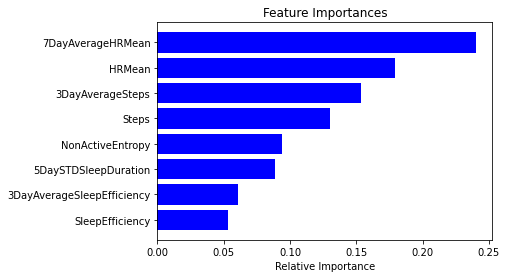

In [1276]:
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [feature_key[i][0] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

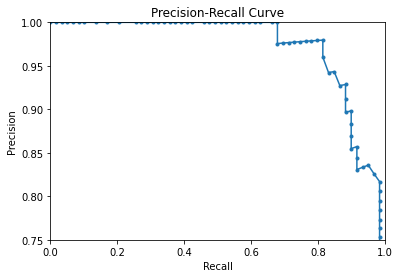

In [1196]:
# Precision-recall curve
lr_probs = model.predict_proba(X_test)
lr_probs = lr_probs[:,1]
# Imported function
lr_precision, lr_recall, thresholds = precision_recall_curve(y_test, lr_probs)
plt.plot(lr_recall, lr_precision, marker='.', label='Random Forest')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.axis(xmin=0, xmax=1, ymin=0.75, ymax=1)
# show the plot
plt.title('Precision-Recall Curve')
plt.show()

In [1197]:
# Print combos of precision, recall, and accuracy
precrec = list(zip(lr_precision, lr_recall, thresholds))
sorted_precrec = sorted(precrec, key=lambda x: x[1], reverse=True)

In [1198]:
sorted_precrec

[(0.6941176470588235, 1.0, 0.086),
 (0.6904761904761905, 0.9830508474576272, 0.092),
 (0.6987951807228916, 0.9830508474576272, 0.114),
 (0.7073170731707317, 0.9830508474576272, 0.116),
 (0.7160493827160493, 0.9830508474576272, 0.122),
 (0.725, 0.9830508474576272, 0.124),
 (0.7341772151898734, 0.9830508474576272, 0.126),
 (0.7435897435897436, 0.9830508474576272, 0.132),
 (0.7532467532467533, 0.9830508474576272, 0.164),
 (0.7631578947368421, 0.9830508474576272, 0.198),
 (0.7733333333333333, 0.9830508474576272, 0.206),
 (0.7837837837837838, 0.9830508474576272, 0.212),
 (0.7945205479452054, 0.9830508474576272, 0.218),
 (0.8055555555555556, 0.9830508474576272, 0.266),
 (0.8169014084507042, 0.9830508474576272, 0.288),
 (0.8260869565217391, 0.9661016949152542, 0.318),
 (0.835820895522388, 0.9491525423728814, 0.36),
 (0.8333333333333334, 0.9322033898305084, 0.4),
 (0.8307692307692308, 0.9152542372881356, 0.436),
 (0.84375, 0.9152542372881356, 0.458),
 (0.8571428571428571, 0.9152542372881356, 0

# Can we predict on a table with one row per participant (16 rows)?
*Haven't tried using less features yet*

## K generalized

In [1059]:
feats = list(features.columns)
feats.remove('Date')
feats.remove('User')
feats.remove('StartSleep')
feats.remove('EndSleep')
first_row = [0] * len(feats)
compact_df = pd.DataFrame([first_row], columns=feats)
for user in features.User.unique():
    for f in feats:
        compact_df.loc[user,f] = features.loc[features['User']==user, f].mean()
compact_df.drop([0], inplace=True)

In [1060]:
# normalize by column
def norm(col):
    copy_col = []
    for e in col:
        copy_col.append((e - min(col))/(max(col) - min(col)))
    return copy_col

In [1281]:
# Adjust function for K folds, don't need to normalize by user anymore
def fit_table_k_2(table, reg):
    # See if there are any NaNs
    print(table.isnull().sum())
    
    # Remove NaN
    table.dropna(axis=0, inplace=True)
    
    # Split inputs and outputs
    X = table.loc[:,table.columns != 'Burnout']
    y = table[['Burnout']]

    # use stratified k fold so accuracy score minimizes bias in train/test split
    skf = StratifiedKFold(n_splits=3, shuffle=True)
    
    # Initialize df
    model_eval = pd.DataFrame()
    
    # Train logit model 
    for train_index, test_index in skf.split(X, y):
        feats = list(X.columns)
        X_train = table.iloc[train_index].loc[:, feats]
        X_test = table.iloc[test_index][feats]
        y_train = table.iloc[train_index].loc[:,'Burnout']
        y_test = table.iloc[test_index]['Burnout']
        # Print length of training data, non burnout users in training data, non burnout proporiton in training data
        print(len(X_train), sum(y_train), sum(y_train)/len(X_train))
        
        if not reg:
            method = 'newton'
        
       # Normalize features
        X_train.update(X_train.apply(norm, axis=1))
        X_test.update(X_test.apply(norm, axis=1))

        # Logistic Regression
        if not reg:
            logit_model=sm.Logit(y_train, X_train)
            result = logit_model.fit(method=method)
        else:
            model = LogisticRegression(penalty='l2')
            result = model.fit(X_train,y_train)
        
        test_fold = test_model(result, X_test, y_test)
        model_eval = pd.concat([model_eval, test_fold], axis= 0)
    
    model_eval.set_index(np.array(range(1,4)), drop=True, inplace=True)
    model_eval.loc['FinalScores'] = model_eval.mean()
    return model_eval

In [1062]:
evaltable = fit_table_k_2(compact_df, reg=True)

CupsofCaffeine           0
AlcoholicDrinks          0
WakeMethod(0-2)          0
TimeToFallAsleep(0-5)    0
HoursWorked              0
                        ..
3DaySTDRelaxEvening      0
5DaySTDRelaxEvening      0
7DaySTDRelaxEvening      0
WRI                      0
Burnout                  0
Length: 122, dtype: int64
10 6.0 0.6
11 7.0 0.6363636363636364


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


11 7.0 0.6363636363636364


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

In [1063]:
evaltable

,Accuracy,Precision,Recall,F1
1,0.833333,0.8,1.000000,0.888889
2,0.600000,0.6,1.000000,0.750000
3,0.400000,NaN,0.000000,NaN
FinalScores,0.611111,0.7,0.666667,0.819444


## Random forest

In [1064]:
feats = list(features.columns)
feats.remove('Date')
feats.remove('User')
feats.remove('StartSleep')
feats.remove('EndSleep')
first_row = [0] * len(feats)
compact_df = pd.DataFrame([first_row], columns=feats)
for user in features.User.unique():
    for f in feats:
        compact_df.loc[user,f] = features.loc[features['User']==user, f].mean()
compact_df.drop([0], inplace=True)

In [1065]:
evaltable, X_train, model, X_test, y_test = rf(compact_df, max_features=int(1/3 * (len(compact_df.columns)-1)), n_estimators=500, max_depth=None)

In [1066]:
evaltable

,Accuracy,Precision,Recall,F1
1,0.500000,0.500000,1.0,0.666667
2,0.666667,0.666667,1.0,0.800000
3,0.666667,1.000000,0.5,0.666667
4,0.333333,0.500000,0.5,0.500000
5,0.666667,0.666667,1.0,0.800000
FinalScores,0.566667,0.666667,0.8,0.686667
